In [1]:
import numpy as np
import cv2
import threading
import time
import matplotlib.pyplot as plt

In [8]:
class WebcamVideoStream:
    
    def __init__(self, src=0, api=None):
        self.stream = cv2.VideoCapture(src, api) if api else cv2.VideoCapture(src)
        
        #self.stream.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        #self.stream.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        self.stream.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))
        #self.stream.set(cv2.CAP_PROP_FPS, 30)
        #print(self.stream.get(cv2.CAP_PROP_FPS))
        
        self.frame = None
        self.stopped = False
        self.frame_counter = []
        
    def start(self):
        threading.Thread(target=self.update, args=()).start()
        return self

    def stop(self):
        self.stopped = True
        self.stream.release()
        
    def update(self):
        while not self.stopped:
            (self.grabbed, self.frame) = self.stream.read()
            self.frame_counter.append(time.time())
            
    def read(self):
        return self.frame

    def get_frame_diffs(self):
        return 1.0/np.diff(np.array(self.frame_counter))
        
    def get_avg_fps(self):
        return self.get_frame_diffs().mean()

In [9]:
class VideoWriter:
    
    def __init__(self, vs):
        self.fps = 20.0
        self.vs = vs
        self.stopped = False
        self.frame_counter = []
        
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.out = cv2.VideoWriter('test_video.avi', fourcc, self.fps, (int(vs.stream.get(3)), int(vs.stream.get(4))))
        
    def start(self):
        self.t_start = time.time()
        threading.Thread(target=self.update, args=()).start()
        return self
    
    def stop(self):
        self.stopped = True
        
    def update(self):
        while not self.stopped:
            if time.time() < self.t_start + 1./self.fps * float(len(self.frame_counter)):
                continue

            frame = self.vs.read()
            if frame is not None:
                self.out.write(frame)
                self.frame_counter.append(time.time())
                
    def get_frame_diffs(self):
        return 1.0/np.diff(np.array(self.frame_counter))
        
    def get_avg_fps(self):
        return self.get_frame_diffs().mean()                

In [ ]:
vs = WebcamVideoStream(src=0, api=cv2.CAP_OPENCV_MJPEG)  # for IR usb camera api=cv2.CAP_DSHOW
#vs = WebcamVideoStream(src=0)
vs.start()

#vw = VideoWriter(vs)
#vw.start()

try:
    while True:
        frame = vs.read()
        if frame is not None:
            cv2.imshow("Frame", frame)

        k = cv2.waitKey(33)
        if k == ord('q'):
            break
finally:
    cv2.destroyAllWindows()
    #vw.stop()
    vs.stop()

Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\inhibition\.conda\envs\runsit\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\inhibition\.conda\envs\runsit\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-6f1a9fb9d68b>", line 27, in update
MemoryError


In [7]:
vs.stop()

In [6]:
vs.get_avg_fps()

<ipython-input-2-3fced249b0a8>:33: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.diff(np.array(self.frame_counter))


inf

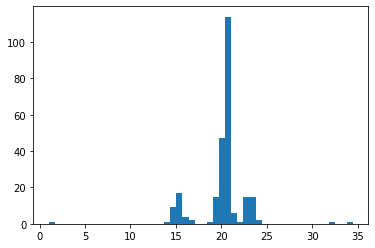

In [25]:
_ = plt.hist(vs.get_frame_diffs(), 50)

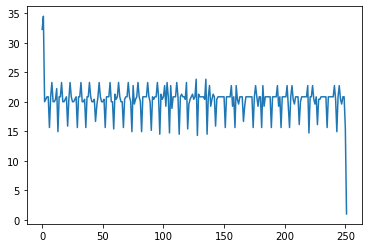

In [26]:
plt.plot(vs.get_frame_diffs())